In [5]:
!pip install pandas numpy matplotlib seaborn surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505180 sha256=6e9e0f6476f5d0fc1fb0df7380059b91e5c3ee3bb3105f5c47545a0c33454847
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


**Import Libraries**

In [6]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns


**Loading Dataset**

In [7]:
# Load datasets
user_interaction = pd.read_csv('user_interaction.csv')
meta_data = pd.read_csv('metadata.csv')

# Print column names to verify
print("User Interaction Columns:", user_interaction.columns)
print("Meta Data Columns:", meta_data.columns)


User Interaction Columns: Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at'], dtype='object')
Meta Data Columns: Index(['author_id', 'pratilipi_id', 'category_name', 'reading_time',
       'updated_at', 'published_at'],
      dtype='object')


**Data Cleaning & Preprocessing**

In [8]:
# Convert scientific notation to standard integers
user_interaction['user_id'] = user_interaction['user_id'].astype(str)
user_interaction['pratilipi_id'] = user_interaction['pratilipi_id'].astype(str)
meta_data['author_id'] = meta_data['author_id'].astype(str)
meta_data['pratilipi_id'] = meta_data['pratilipi_id'].astype(str)

# Fix 'updated_at' in user_interaction (assuming it's in minutes:seconds.milliseconds format)
def convert_to_seconds(time_str):
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return np.nan

# Check if 'updated_at' column exists in user_interaction
if 'updated_at' in user_interaction.columns:
    user_interaction['updated_at'] = user_interaction['updated_at'].apply(convert_to_seconds)
else:
    raise KeyError("Column 'updated_at' not found in user_interaction.csv")


**Mergeing Dataset**

In [9]:
# Merge datasets on pratilipi_id
data = pd.merge(user_interaction, meta_data, on='pratilipi_id', how='left')
print(data.head())

# Check if 'updated_at_x' and 'updated_at_y' columns exist after merging
if 'updated_at_x' not in data.columns:
    raise KeyError("Column 'updated_at_x' not found after merging datasets")
if 'updated_at_y' not in data.columns:
    raise KeyError("Column 'updated_at_y' not found after merging datasets")

# Convert timestamps to datetime
data['updated_at_x'] = pd.to_datetime(data['updated_at_x'], unit='s', origin='unix')
data['updated_at_y'] = pd.to_datetime(data['updated_at_y'], format='%Y-%m-%d %H:%M:%S')  # Updated format


            user_id      pratilipi_id  read_percent  updated_at_x  \
0  5506791961876448  1377786228262109         100.0           NaN   
1  5506791961876448  1377786228262109         100.0           NaN   
2  5506791961876448  1377786228262109         100.0           NaN   
3  5506791971543560  1377786223038206          40.0           NaN   
4  5506791971543560  1377786223038206          40.0           NaN   

           author_id category_name  reading_time         updated_at_y  \
0  -2270332349684758        novels         376.0  2022-03-15 18:39:52   
1  -2270332349684758        family         376.0  2022-03-15 18:39:52   
2  -2270332349684758       romance         376.0  2022-03-15 18:39:52   
3  -2270332348374323       romance         361.0  2021-03-17 11:48:11   
4  -2270332348374323      suspense         361.0  2021-03-17 11:48:11   

          published_at  
0  2022-03-15 18:39:52  
1  2022-03-15 18:39:52  
2  2022-03-15 18:39:52  
3  2021-03-16 19:09:19  
4  2021-03-16 19:09:1

**Feature Engineering**

In [10]:
# Feature engineering
data['days_since_published'] = (data['updated_at_x'] - data['updated_at_y']).dt.days
data['days_since_interaction'] = (data['updated_at_x'].max() - data['updated_at_x']).dt.days

# Handle missing values
data.fillna({'category_name': 'Unknown', 'reading_time': 0}, inplace=True)

# Encode categorical features
data = pd.get_dummies(data, columns=['category_name'], drop_first=True)

# Sort data by 'updated_at_x' (user interaction timestamp)
data = data.sort_values(by='updated_at_x')


**Splitting Data into Training and Testing Sets**

In [11]:
# Split data into training and testing sets
train_size = int(0.75 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")


Training set size: 3724965
Testing set size: 1241656


**Loading Data into Surprise Format**

In [12]:
# Load data into Surprise format
reader = Reader(rating_scale=(0, 100))
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'pratilipi_id', 'read_percent']], reader)


**Training SVD Model**

In [13]:
# Train SVD model
model = SVD()
cross_validate(model, train_data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train on full training set
trainset = train_data_surprise.build_full_trainset()
model.fit(trainset)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    22.0729 22.1920 22.3052 22.3183 22.1397 22.2056 0.0946  
MAE (testset)     6.4170  6.3987  6.4532  6.4717  6.4341  6.4349  0.0258  
Fit time          85.48   90.70   100.50  100.89  98.17   95.15   6.06    
Test time         13.93   17.83   14.30   16.29   17.44   15.96   1.59    


**Getting Top 5 Predictions**

In [14]:
# Predict top 5 pratilipis for each user
def get_top_n_predictions(model, user_id, n=5):
    user_interactions = train_data[train_data['user_id'] == user_id]
    user_unread_pratilipis = set(data['pratilipi_id']) - set(user_interactions['pratilipi_id'])
    predictions = [model.predict(user_id, pratilipi_id) for pratilipi_id in user_unread_pratilipis]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [pred.iid for pred in top_n]

# Example: Predict for user_id = '5.50679E+15'
top_5_pratilipis = get_top_n_predictions(model, user_id='5.50679E+15', n=5)
print(f"Top 5 recommended pratilipis for user 5.50679E+15: {top_5_pratilipis}")


Top 5 recommended pratilipis for user 5.50679E+15: ['254636438755016', '1377786226905775', '1377786225048624', '1377786224506528', '1377786220543171']


**Evaluating on Test Data**

In [15]:
# Evaluate on test data
test_data_surprise = Dataset.load_from_df(test_data[['user_id', 'pratilipi_id', 'read_percent']], reader)
testset = test_data_surprise.build_full_trainset().build_testset()
predictions = model.test(testset)


**Calculating Precision@5**

In [16]:
# Calculate Precision@5
def precision_at_k(predictions, k=5):
    top_k = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
    relevant = sum(1 for pred in top_k if pred.r_ui > 50)  # Assuming read_percent > 50% is relevant
    return relevant / k

precision = precision_at_k(predictions, k=5)
print(f"Precision@5: {precision}")


Precision@5: 1.0


**Calculating Accuracy@5**

In [17]:
# Calculate Accuracy@5
def accuracy_at_k(predictions, k=5):
    top_k = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
    relevant = sum(1 for pred in top_k if pred.r_ui > 50)  # Assuming read_percent > 50% is relevant
    return (relevant / k) * 100

accuracy = accuracy_at_k(predictions, k=5)
print(f"Accuracy@5: {accuracy}%")


Accuracy@5: 100.0%


**Visualization - Read Percentage Distribution**

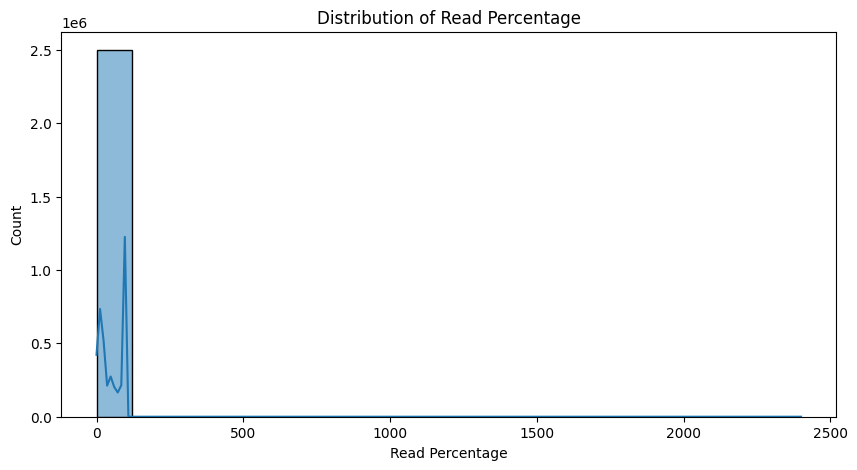

In [18]:
# Plot Read Percentage Distribution
plt.figure(figsize=(10, 5))
sns.histplot(user_interaction['read_percent'], bins=20, kde=True)
plt.xlabel("Read Percentage")
plt.ylabel("Count")
plt.title("Distribution of Read Percentage")
plt.show()


**Visualization - Top 10 Most Popular Storiesa**

<ipython-input-19-e30b369855b1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_stories.index, y=top_stories.values, palette="viridis")


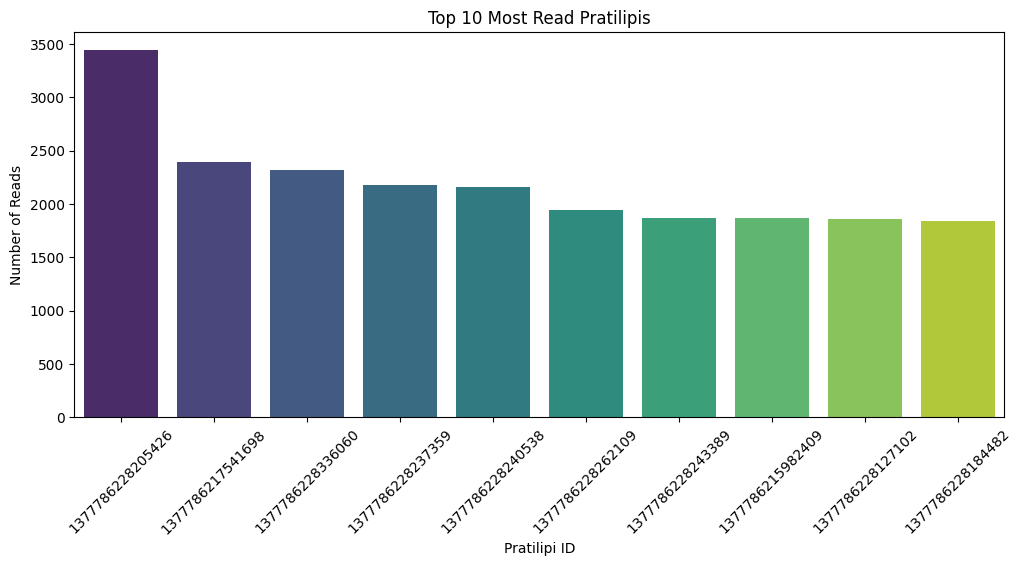

In [19]:
# Top 10 Most Popular Stories
top_stories = user_interaction['pratilipi_id'].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_stories.index, y=top_stories.values, palette="viridis")
plt.xlabel("Pratilipi ID")
plt.ylabel("Number of Reads")
plt.title("Top 10 Most Read Pratilipis")
plt.xticks(rotation=45)
plt.show()


**Visualization - Category-wise Story Distribution**

<ipython-input-21-e6f3b137746a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=meta_data['category_name'], order=meta_data['category_name'].value_counts().index, palette="coolwarm")


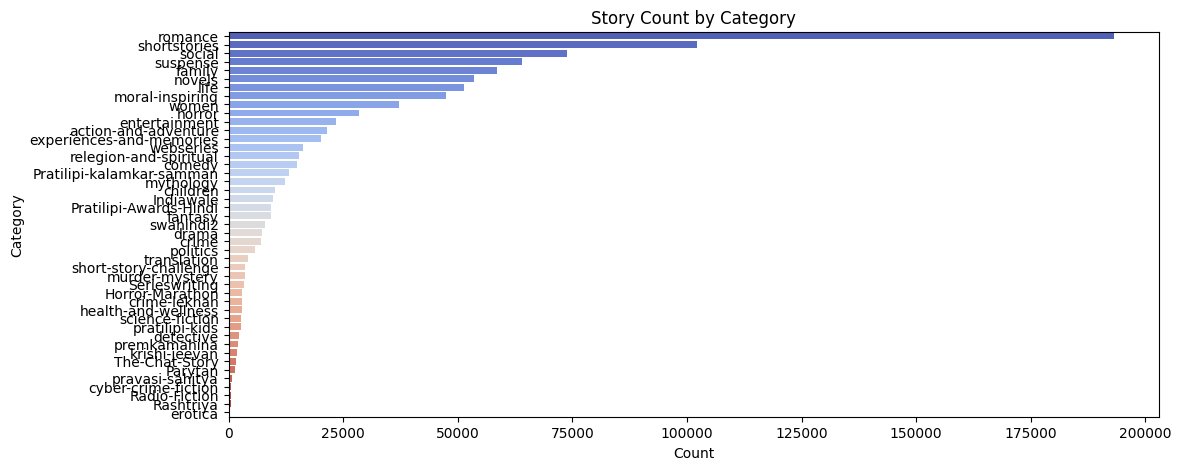

In [21]:
# Category-wise Story Distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=meta_data['category_name'], order=meta_data['category_name'].value_counts().index, palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Story Count by Category")
plt.show()
